In [1]:
%pip install pycocotools safetensors

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os 

# Use local dataset path from kagglehub download
base_path = "/home/loc-dang/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2/coco2017"
print("Annotations:", os.listdir(os.path.join(base_path, "annotations")))
print("Training images:", len(os.listdir(os.path.join(base_path, "train2017"))))
print("Validation images:", len(os.listdir(os.path.join(base_path, "val2017"))))
print("Test images:", len(os.listdir(os.path.join(base_path, "test2017"))))

Annotations: ['captions_val2017.json', 'instances_val2017.json', 'captions_train2017.json', 'person_keypoints_val2017.json', 'instances_train2017.json', 'person_keypoints_train2017.json']
Training images: 118287
Validation images: 5000
Test images: 40670


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.7.1+cu126
CUDA available: True
CUDA version: 12.6
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

In [5]:
# Test DoubleConv block
print("🧪 Testing DoubleConv:")
test_input = torch.randn(1, 3, 100, 100)  # [batch, channels, height, width]
double_conv = DoubleConv(3, 64)
output = double_conv(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Size change: {test_input.shape[-1]} -> {output.shape[-1]}")
print(f"Pixels lost: {test_input.shape[-1] - output.shape[-1]} (due to unpadded conv)")

🧪 Testing DoubleConv:
Input shape: torch.Size([1, 3, 100, 100])
Output shape: torch.Size([1, 64, 96, 96])
Size change: 100 -> 96
Pixels lost: 4 (due to unpadded conv)


In [6]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x):
        x = self.max_pool(x)
        x = self.double_conv(x)
        return x

In [7]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        batch, channels, x2_height,x2_width = x2.shape
        up_sample = self.up_conv(x1)
        each_size = (x2_height - up_sample.shape[2]) // 2  

        x2_crop = x2[:,:,each_size:x2_height - each_size, each_size:x2_width - each_size]
        concatenate = torch.cat([up_sample, x2_crop], dim=1)

        return self.double_conv(concatenate)

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()

        self.encoder_0 = DoubleConv(in_channels=in_channels, out_channels=64)
        self.encoder_1 = Encoder(64, 128)
        self.encoder_2 = Encoder(128, 256)
        self.encoder_3 = Encoder(256, 512)
        self.encoder_4 = Encoder(512, 1024)

        self.decoder_0 = Decoder(1024, 512)
        self.decoder_1 = Decoder(512, 256)
        self.decoder_2 = Decoder(256, 128)
        self.decoder_3 = Decoder(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1, padding=0)

    def forward(self, x):
        x1 = self.encoder_0(x)
        x2 = self.encoder_1(x1)
        x3 = self.encoder_2(x2)
        x4 = self.encoder_3(x3)
        x5 = self.encoder_4(x4)

        x = self.decoder_0(x5, x4)
        x = self.decoder_1(x, x3)
        x = self.decoder_2(x, x2)
        x = self.decoder_3(x, x1)
        return self.out(x)



In [9]:
# Test UNet Architecture
print("🚀 Testing Complete U-Net:")

# Create model
model = UNet(in_channels=3, num_classes=2)  # RGB input, binary segmentation
print(f"Model created: {model.__class__.__name__}")

# Test with dummy input
test_input = torch.randn(1, 3, 572, 572)  # Original paper input size
print(f"Input shape: {test_input.shape}")

# Forward pass
with torch.no_grad():
    output = model(test_input)
    
print(f"Output shape: {output.shape}")
print(f"Input size: {test_input.shape[-1]} -> Output size: {output.shape[-1]}")
print(f"Size reduction: {test_input.shape[-1] - output.shape[-1]} pixels")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"Total: {total_params:,}")
print(f"Trainable: {trainable_params:,}")

🚀 Testing Complete U-Net:
Model created: UNet
Input shape: torch.Size([1, 3, 572, 572])
Output shape: torch.Size([1, 2, 388, 388])
Input size: 572 -> Output size: 388
Size reduction: 184 pixels

Model Parameters:
Total: 31,031,810
Trainable: 31,031,810


In [10]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(WeightedCrossEntropyLoss, self).__init__()
    
    def forward(self, logits, targets, weight_map=None):
        loss = F.cross_entropy(logits, targets, reduction='none')
        
        if weight_map is not None:
            loss = loss * weight_map
        return loss.mean()

In [11]:
# Test WeightedCrossEntropyLoss
print("🧪 Testing WeightedCrossEntropyLoss:")

# Create dummy data
batch_size, num_classes, height, width = 2, 3, 10, 10
logits = torch.randn(batch_size, num_classes, height, width)
targets = torch.randint(0, num_classes, (batch_size, height, width))
weight_map = torch.ones(batch_size, height, width)

print(f"Logits shape: {logits.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Weight map shape: {weight_map.shape}")

# Test loss
criterion = WeightedCrossEntropyLoss()
loss_without_weights = criterion(logits, targets)
loss_with_weights = criterion(logits, targets, weight_map)

print(f"\nLoss without weights: {loss_without_weights.item():.4f}")
print(f"Loss with weights: {loss_with_weights.item():.4f}")
print("✅ Loss function works!")

🧪 Testing WeightedCrossEntropyLoss:
Logits shape: torch.Size([2, 3, 10, 10])
Targets shape: torch.Size([2, 10, 10])
Weight map shape: torch.Size([2, 10, 10])

Loss without weights: 1.5318
Loss with weights: 1.5318
✅ Loss function works!


In [12]:
import cv2
import numpy as np
from scipy import ndimage
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

def generate_weight_map(mask, w0=10, sigma=5):
    """
    Generate weight map for U-Net training
    
    Args:
        mask: Multi-class mask [H, W] (0=background, 1-80=classes)
        w0: Weight of separation between cells
        sigma: Standard deviation for Gaussian
    
    Returns:
        weight_map: Weight map [H, W]
    """
    # Bước 1: Tính class weights wc(x)
    background_pixels = np.sum(mask == 0)
    foreground_pixels = np.sum(mask > 0)  # ✅ FIX: Any non-zero class
    
    if foreground_pixels > 0:
        class_ratio = background_pixels / foreground_pixels
    else:
        class_ratio = 1.0
    
    # Tạo class weight map
    wc = np.ones_like(mask, dtype=np.float32)
    wc[mask > 0] = class_ratio  # ✅ FIX: Apply to all foreground classes
    
    # Bước 2: Tính boundary weights
    distance = distance_transform_edt(mask == 0)  # Distance từ background
    
    # Bước 3: Apply Gaussian weight tại boundaries
    boundary_weight = w0 * np.exp(-(distance**2) / (2 * sigma**2))
    
    # Bước 4: Combine weights
    weight_map = wc + boundary_weight
    
    return weight_map

def visualize_weight_map(mask, weight_map):
    """Visualize mask and weight map side by side"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original mask
    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title('Original Mask')
    axes[0].axis('off')
    
    # Weight map
    axes[1].imshow(weight_map, cmap='hot')
    axes[1].set_title('Weight Map')
    axes[1].axis('off')
    
    # Colorbar
    im = axes[2].imshow(weight_map, cmap='hot')
    axes[2].set_title('Weight Map (with colorbar)')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

🧪 Testing Weight Map Generation:
Mask shape: (100, 100)
Background pixels: 9200
Foreground pixels: 800
Weight map shape: (100, 100)
Weight range: 1.00 - 21.50


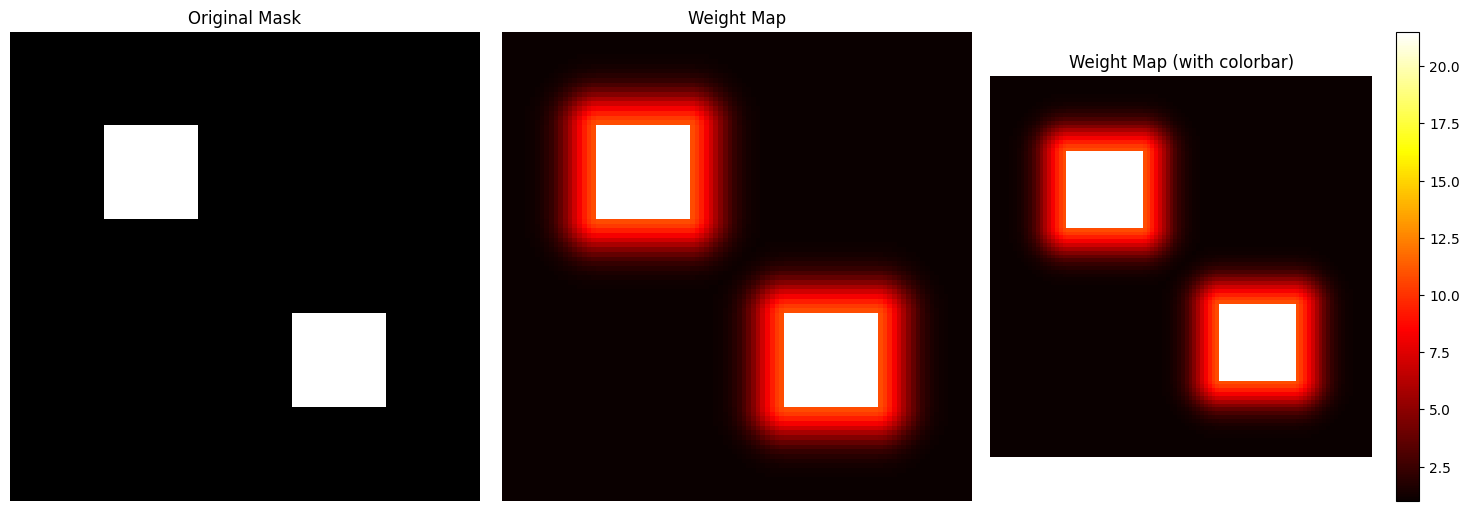

In [13]:
# Test Weight Map Generation
print("🧪 Testing Weight Map Generation:")

# Create dummy binary mask (simulating cells)
mask = np.zeros((100, 100), dtype=np.uint8)
mask[20:40, 20:40] = 1  # Cell 1
mask[60:80, 60:80] = 1  # Cell 2

print(f"Mask shape: {mask.shape}")
print(f"Background pixels: {np.sum(mask == 0)}")
print(f"Foreground pixels: {np.sum(mask == 1)}")

# Generate weight map
weight_map = generate_weight_map(mask, w0=10, sigma=5)
print(f"Weight map shape: {weight_map.shape}")
print(f"Weight range: {weight_map.min():.2f} - {weight_map.max():.2f}")

# Visualize
visualize_weight_map(mask, weight_map)

# Import dataset

In [14]:
import json
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class COCOSegmentationDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None, target_size=(572, 572), max_samples=None):
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.transform = transform
        self.target_size = target_size

        self.image_ids = list(self.coco.imgs.keys())
        
        # ✅ Limit dataset size
        if max_samples is not None:
            self.image_ids = self.image_ids[:max_samples]
            print(f"🔥 Dataset limited to {len(self.image_ids)} samples")

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # Bước 1: Load image
        image_id = self.image_ids[idx]
        image_info = self.coco.imgs[image_id]
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        
        # Bước 2: Generate multi-class mask
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Create multi-class mask
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        for ann in anns:
            if 'segmentation' in ann:
                category_id = ann['category_id']
                # Convert COCO category_id to class index (1-80)
                class_idx = self.coco.getCatIds().index(category_id) + 1
                
                # Generate mask for this annotation
                rle = coco_mask.frPyObjects(ann['segmentation'], 
                                        image_info['height'], 
                                        image_info['width'])
                m = coco_mask.decode(rle)
                if len(m.shape) == 3:
                    m = m[:, :, 0]
                
                # Assign class index to mask
                mask[m > 0] = class_idx
        
        # Bước 3: Resize image and mask
        image = image.resize(self.target_size)
        mask = Image.fromarray(mask).resize(self.target_size, Image.NEAREST)
        mask = np.array(mask)
        
        # Bước 4: Generate weight map
        weight_map = generate_weight_map(mask, w0=10, sigma=5)
        
        # Bước 5: Apply transforms
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        
        mask = torch.from_numpy(mask).long()
        weight_map = torch.from_numpy(weight_map).float()
        
        return image, mask, weight_map

def get_coco_dataloaders(base_path, batch_size=4, max_samples=100):
    """Create COCO train/val dataloaders with limited samples"""
    # Define transforms
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets with limited samples
    train_dataset = COCOSegmentationDataset(
        root_dir=os.path.join(base_path, "train2017"),
        annotation_file=os.path.join(base_path, "annotations/instances_train2017.json"),
        transform=train_transform,
        max_samples=max_samples  # ✅ Limit train to 2000
    )
    
    val_dataset = COCOSegmentationDataset(
        root_dir=os.path.join(base_path, "val2017"),
        annotation_file=os.path.join(base_path, "annotations/instances_val2017.json"),
        transform=train_transform,
        max_samples=max_samples//4  # ✅ Limit val to 500
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [15]:
import os 

# Use local dataset path from kagglehub download
base_path = "/home/loc-dang/.cache/kagglehub/datasets/awsaf49/coco-2017-dataset/versions/2/coco2017"

print("Annotations:", os.listdir(os.path.join(base_path, "annotations")))
print("Training images:", len(os.listdir(os.path.join(base_path, "train2017"))))
print("Validation images:", len(os.listdir(os.path.join(base_path, "val2017"))))
print("Test images:", len(os.listdir(os.path.join(base_path, "test2017"))))

Annotations: ['captions_val2017.json', 'instances_val2017.json', 'captions_train2017.json', 'person_keypoints_val2017.json', 'instances_train2017.json', 'person_keypoints_train2017.json']
Training images: 118287
Validation images: 5000
Test images: 40670


In [16]:
# Test COCO Dataset
print("🧪 Testing COCO Dataset:")

# Create dataloaders
try:
    train_loader, val_loader = get_coco_dataloaders(base_path, batch_size=2)
    print("✅ Dataloaders created successfully!")
    
    print(f"Train dataset size: {len(train_loader.dataset)}")
    print(f"Val dataset size: {len(val_loader.dataset)}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    
except Exception as e:
    print(f"❌ Error creating dataloaders: {e}")

# Test loading one batch
print("\n🔍 Testing data loading:")
try:
    # Get one batch from train loader
    batch_iter = iter(train_loader)
    images, masks, weight_maps = next(batch_iter)
    
    print(f"✅ Batch loaded successfully!")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    print(f"Weight maps shape: {weight_maps.shape}")
    print(f"Images dtype: {images.dtype}")
    print(f"Masks dtype: {masks.dtype}")
    print(f"Weight maps dtype: {weight_maps.dtype}")
    
    # Check data ranges
    print(f"\nData ranges:")
    print(f"Images: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Masks: [{masks.min()}, {masks.max()}]")
    print(f"Weight maps: [{weight_maps.min():.3f}, {weight_maps.max():.3f}]")
    
except Exception as e:
    print(f"❌ Error loading batch: {e}")

🧪 Testing COCO Dataset:
loading annotations into memory...
Done (t=5.87s)
creating index...
index created!
🔥 Dataset limited to 100 samples
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
🔥 Dataset limited to 25 samples
✅ Dataloaders created successfully!
Train dataset size: 100
Val dataset size: 25
Train batches: 50
Val batches: 13

🔍 Testing data loading:
✅ Batch loaded successfully!
Images shape: torch.Size([2, 3, 572, 572])
Masks shape: torch.Size([2, 572, 572])
Weight maps shape: torch.Size([2, 572, 572])
Images dtype: torch.float32
Masks dtype: torch.int64
Weight maps dtype: torch.float32

Data ranges:
Images: [-2.118, 2.640]
Masks: [0, 72]
Weight maps: [1.000, 13.907]


In [17]:
import torch.optim as optim
from tqdm import tqdm
import time
from safetensors.torch import save_file, load_file
import torch.nn.functional as F

def train_unet_coco():
    """Complete U-Net training pipeline with SafeTensors"""
    
    print("🚀 INITIALIZING U-NET TRAINING:")
    
    # 1. Create model with 81 classes (0=background + 80 COCO)
    model = UNet(in_channels=3, num_classes=81).to(device)
    print(f"✅ Model created: {model.out.out_channels} classes")
    
    # 2. Loss function & optimizer
    criterion = WeightedCrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # 3. Load data
    train_loader, val_loader = get_coco_dataloaders(base_path, batch_size=4)
    print(f"✅ Data loaded: {len(train_loader)} train batches")
    
    # 4. Training parameters
    num_epochs = 2  # Start small for testing
    best_loss = float('inf')
    
    print(f"\n🔥 TRAINING START:")
    print(f"Device: {device}")
    print(f"Epochs: {num_epochs}")
    print(f"Batch size: 4")
    print(f"Learning rate: 1e-4")
    
    for epoch in range(num_epochs):
        print(f"\n📈 EPOCH {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Training")
        
        for batch_idx, (images, masks, weight_maps) in enumerate(train_pbar):
            # Move to device
            images = images.to(device)
            masks = masks.to(device)
            weight_maps = weight_maps.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            
            # ✅ FIX: Resize targets to match output size
            output_size = outputs.shape[-2:]  # [388, 388]
            masks_resized = F.interpolate(
                masks.unsqueeze(1).float(), 
                size=output_size, 
                mode='nearest'
            ).squeeze(1).long()
            
            weight_maps_resized = F.interpolate(
                weight_maps.unsqueeze(1), 
                size=output_size, 
                mode='bilinear', 
                align_corners=False
            ).squeeze(1)
            
            # Calculate loss with resized targets
            loss = criterion(outputs, masks_resized, weight_maps_resized)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{train_loss/(batch_idx+1):.4f}'
            })
            
            # Early break for testing
            if batch_idx >= 10:  # Only train on 10 batches for testing
                break
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        print(f"🔍 Validation...")
        with torch.no_grad():
            for batch_idx, (images, masks, weight_maps) in enumerate(val_loader):
                images = images.to(device)
                masks = masks.to(device)
                weight_maps = weight_maps.to(device)
                
                outputs = model(images)
                
                # ✅ FIX: Resize targets for validation too
                output_size = outputs.shape[-2:]
                masks_resized = F.interpolate(
                    masks.unsqueeze(1).float(), 
                    size=output_size, 
                    mode='nearest'
                ).squeeze(1).long()
                
                weight_maps_resized = F.interpolate(
                    weight_maps.unsqueeze(1), 
                    size=output_size, 
                    mode='bilinear', 
                    align_corners=False
                ).squeeze(1)
                
                loss = criterion(outputs, masks_resized, weight_maps_resized)
                val_loss += loss.item()
                
                # Early break for testing
                if batch_idx >= 5:
                    break
        
        # Print epoch results
        avg_train_loss = train_loss / 11
        avg_val_loss = val_loss / 6
        
        print(f"📊 Epoch {epoch+1} Results:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        
        # Save best model with SafeTensors
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            
            # Save model state dict as SafeTensors
            save_file(model.state_dict(), 'best_unet_coco.safetensors')
            print(f"✅ Best model saved as SafeTensors! Loss: {best_loss:.4f}")
            
            # Also save training metadata
            metadata = {
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'learning_rate': 1e-4,
                'num_classes': 81,
                'architecture': 'U-Net',
                'dataset': 'COCO-2017'
            }
            
            # Save metadata separately
            import json
            with open('training_metadata.json', 'w') as f:
                json.dump(metadata, f, indent=2)
            print(f"📋 Training metadata saved!")
    
    print(f"\n🎉 TRAINING COMPLETED!")
    return model

def load_trained_model(model_path='best_unet_coco.safetensors'):
    """Load model from SafeTensors file"""
    print(f"📂 Loading model from {model_path}")
    
    # Create model architecture
    model = UNet(in_channels=3, num_classes=81).to(device)
    
    # Load weights from SafeTensors
    state_dict = load_file(model_path)
    model.load_state_dict(state_dict)
    
    print(f"✅ Model loaded successfully!")
    return model

# Start training
print("🚀 Starting U-Net Training with SafeTensors...")
trained_model = train_unet_coco()

🚀 Starting U-Net Training with SafeTensors...
🚀 INITIALIZING U-NET TRAINING:
✅ Model created: 81 classes
loading annotations into memory...
Done (t=5.20s)
creating index...
index created!
🔥 Dataset limited to 100 samples
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
🔥 Dataset limited to 25 samples
✅ Data loaded: 25 train batches

🔥 TRAINING START:
Device: cuda
Epochs: 2
Batch size: 4
Learning rate: 1e-4

📈 EPOCH 1/2


Training:  40%|████      | 10/25 [00:09<00:13,  1.07it/s, Loss=15.7400, Avg Loss=17.6718]


🔍 Validation...
📊 Epoch 1 Results:
  Train Loss: 17.6718
  Val Loss: 18.3616
✅ Best model saved as SafeTensors! Loss: 18.3616
📋 Training metadata saved!

📈 EPOCH 2/2


Training:  40%|████      | 10/25 [00:07<00:11,  1.29it/s, Loss=12.2838, Avg Loss=17.7423]


🔍 Validation...
📊 Epoch 2 Results:
  Train Loss: 17.7423
  Val Loss: 23.3407

🎉 TRAINING COMPLETED!


🧪 TESTING TRAINED U-NET MODEL:
📂 Loading model from best_unet_coco.safetensors
✅ Model loaded successfully!
loading annotations into memory...
Done (t=5.34s)
creating index...
index created!
🔥 Dataset limited to 100 samples
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
🔥 Dataset limited to 25 samples
✅ Test batch loaded: torch.Size([4, 3, 572, 572])
Predictions shape: torch.Size([4, 388, 388])
Output classes range: [1, 1]


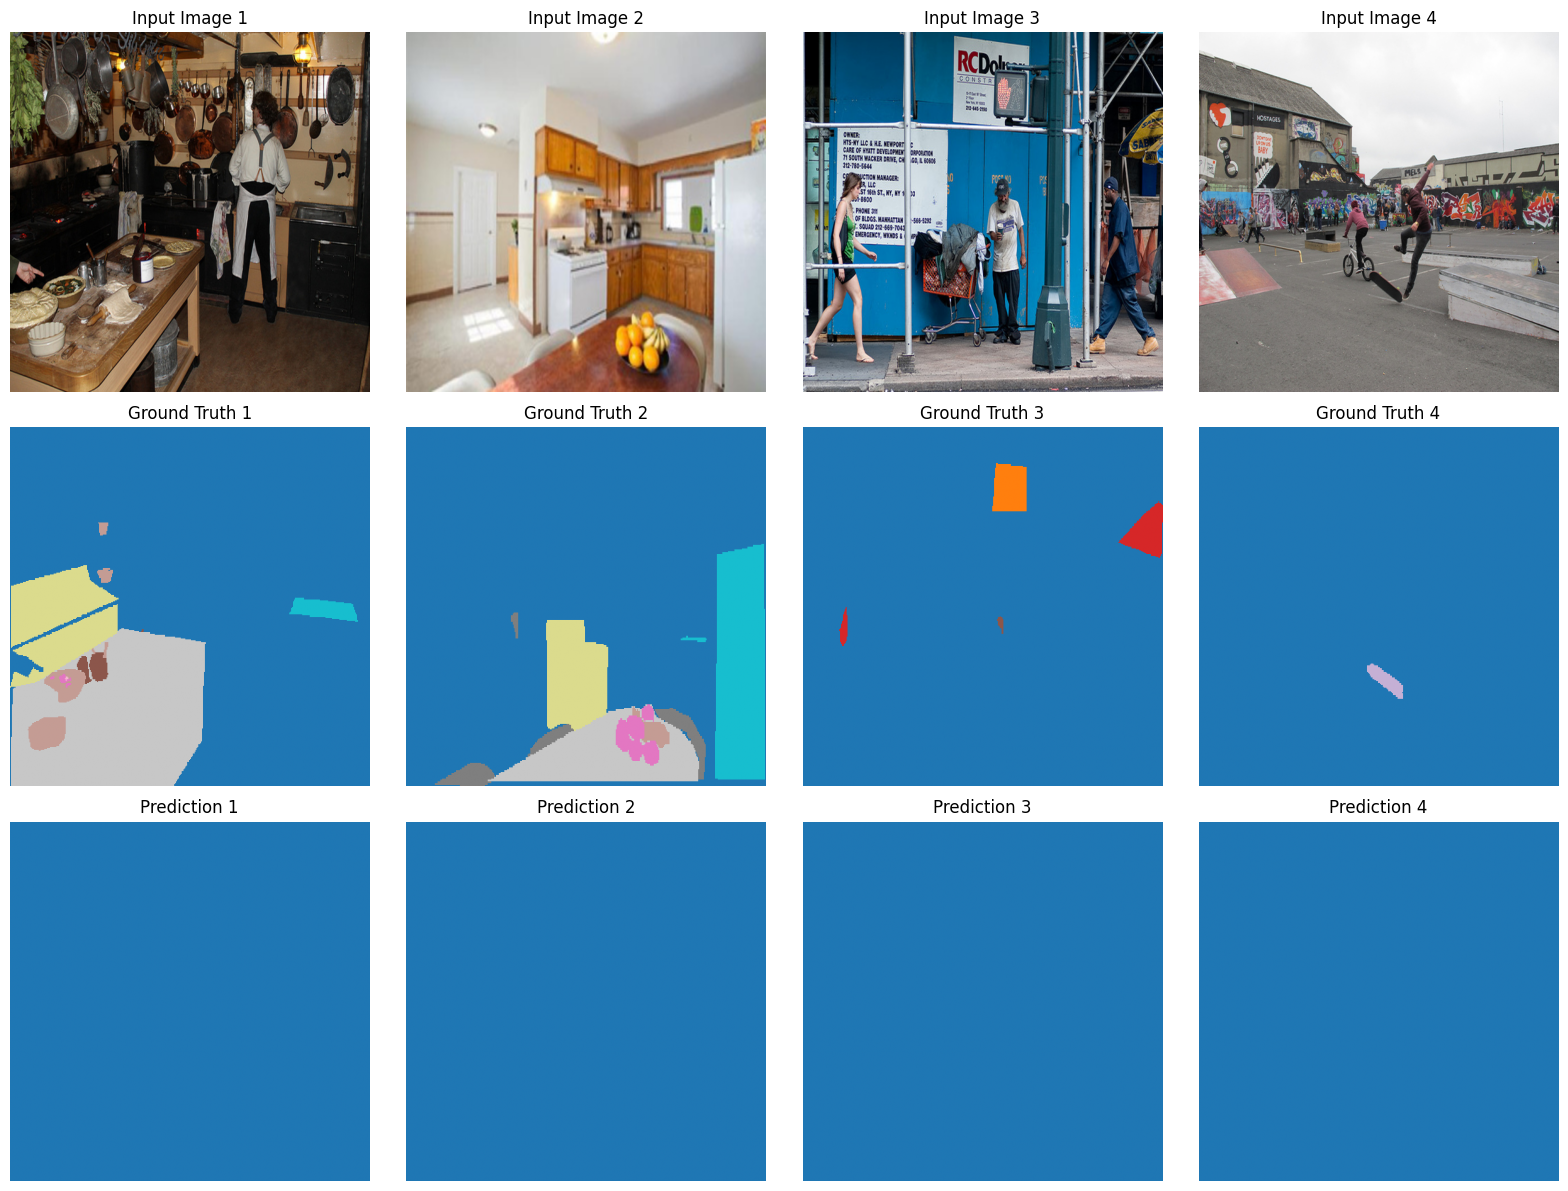


📊 PREDICTION STATISTICS:
Sample 1:
  GT classes: [ 0  1 40 42 44 45 46 51 52 61 70 72]
  Pred classes: [1]
Sample 2:
  GT classes: [ 0 47 50 57 59 61 70 72 73]
  Pred classes: [1]
Sample 3:
  GT classes: [ 0  1 10 26 27 42]
  Pred classes: [1]
Sample 4:
  GT classes: [ 0  1  2 37]
  Pred classes: [1]


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def test_and_visualize_model(model_path='best_unet_coco.safetensors', num_samples=4):
    """Test trained model and visualize results"""
    
    print("🧪 TESTING TRAINED U-NET MODEL:")
    
    # 1. Load trained model
    model = load_trained_model(model_path)
    model.eval()
    
    # 2. Get test data
    _, val_loader = get_coco_dataloaders(base_path, batch_size=num_samples)
    
    # 3. Get one batch for testing
    batch_iter = iter(val_loader)
    images, gt_masks, weight_maps = next(batch_iter)
    
    print(f"✅ Test batch loaded: {images.shape}")
    
    # 4. Run inference
    with torch.no_grad():
        images_gpu = images.to(device)
        outputs = model(images_gpu)
        
        # Get predictions
        predictions = torch.softmax(outputs, dim=1)
        pred_masks = torch.argmax(predictions, dim=1)
        
        print(f"Predictions shape: {pred_masks.shape}")
        print(f"Output classes range: [{pred_masks.min()}, {pred_masks.max()}]")
    
    # 5. Visualize results
    visualize_predictions(images, gt_masks, pred_masks, num_samples)

def visualize_predictions(images, gt_masks, pred_masks, num_samples=4):
    """Visualize input images, ground truth masks, and predictions"""
    
    fig, axes = plt.subplots(3, num_samples, figsize=(16, 12))
    
    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    for i in range(num_samples):
        # Denormalize image
        img = images[i].clone()
        for t, m, s in zip(img, mean, std):
            t.mul_(s).add_(m)
        img = torch.clamp(img, 0, 1)
        img_np = img.permute(1, 2, 0).numpy()
        
        # Ground truth mask (resize to match prediction)
        gt_mask = gt_masks[i].numpy()
        gt_resized = np.array(Image.fromarray(gt_mask.astype(np.uint8)).resize((388, 388), Image.NEAREST))
        
        # Prediction mask
        pred_mask = pred_masks[i].cpu().numpy()
        
        # Plot original image
        axes[0, i].imshow(img_np)
        axes[0, i].set_title(f'Input Image {i+1}')
        axes[0, i].axis('off')
        
        # Plot ground truth mask
        axes[1, i].imshow(gt_resized, cmap='tab20', vmin=0, vmax=80)
        axes[1, i].set_title(f'Ground Truth {i+1}')
        axes[1, i].axis('off')
        
        # Plot prediction mask
        axes[2, i].imshow(pred_mask, cmap='tab20', vmin=0, vmax=80)
        axes[2, i].set_title(f'Prediction {i+1}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n📊 PREDICTION STATISTICS:")
    for i in range(num_samples):
        gt_classes = np.unique(gt_masks[i].numpy())
        pred_classes = np.unique(pred_masks[i].cpu().numpy())
        
        print(f"Sample {i+1}:")
        print(f"  GT classes: {gt_classes}")
        print(f"  Pred classes: {pred_classes}")

def calculate_metrics(gt_masks, pred_masks):
    """Calculate basic segmentation metrics"""
    
    # Convert to numpy
    gt_np = gt_masks.numpy()
    pred_np = pred_masks.cpu().numpy()
    
    # Calculate pixel accuracy
    correct_pixels = np.sum(gt_np == pred_np)
    total_pixels = gt_np.size
    pixel_accuracy = correct_pixels / total_pixels
    
    # Calculate IoU for each class
    classes = np.unique(np.concatenate([gt_np.flatten(), pred_np.flatten()]))
    ious = []
    
    for cls in classes:
        if cls == 0:  # Skip background for now
            continue
            
        gt_mask = (gt_np == cls)
        pred_mask = (pred_np == cls)
        
        intersection = np.sum(gt_mask & pred_mask)
        union = np.sum(gt_mask | pred_mask)
        
        if union > 0:
            iou = intersection / union
            ious.append(iou)
    
    mean_iou = np.mean(ious) if ious else 0.0
    
    print(f"\n📈 METRICS:")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Number of classes detected: {len(ious)}")
    
    return pixel_accuracy, mean_iou

# Run testing and visualization
test_and_visualize_model()